In [ ]:
!unzip drive/MyDrive/cifraproriv_cb/train_dataset_ЦБ.zip

Archive:  drive/MyDrive/cifraproriv_cb/train_dataset_ЦБ.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: train.csv               
  inflating: Пояснение к датасету.docx  


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_data = pd.read_csv('train.csv')
new_names = {'Содержание':'content', 'Сервис':'service', 'Приоритет':'priority', 'Статус': 'status', 'Функциональная группа':'group', 'Крайний срок':'deadline', 'Дата обращения':'application_date', 'Тип обращения на момент подачи':'original_type', 'Тип обращения итоговый':'final_type', 'Решение             ':'decision', 'Тип переклассификации':'target', 'Дата восстановления':'repair_date', 'Дата закрытия обращения':'closing_date', 'Критичность':'criticality', 'Влияние':'influence', 'Система':'system', 'Место':'place'}
train_data.rename(columns = new_names, inplace = True)

train_data = train_data.fillna(0)

train_data.repair_date = train_data.repair_date.apply(pd.to_datetime)
train_data.closing_date = train_data.closing_date.apply(pd.to_datetime)

train_data.deadline = train_data.deadline.apply(pd.to_datetime)
train_data.application_date = train_data.application_date.apply(pd.to_datetime)

train_data.head()

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42:00,2018-01-19 09:27:00,Запрос,Запрос,Тест,0,1970-01-01 00:00:00,2018-01-19 09:43:00,4-Нет,3-Малое,База,К
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51:00,2018-01-19 09:36:00,Запрос,Запрос,Тест,0,1970-01-01 00:00:00,2018-01-19 09:41:00,4-Нет,3-Малое,База,К
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51:00,2018-01-25 22:47:00,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47:00,2018-02-02 07:52:00,1-Особая,3-Малое,Система7,Место190
3,.Не включается ПК,АРМ,3-Низкий,Закрыт,ФГ390,2018-01-28 05:50:00,2018-01-25 23:13:00,Инцидент,Инцидент,Выход из стоя БП. Заменён.,0,2018-01-25 23:55:00,2018-01-26 00:00:00,4-Нет,3-Малое,База,Место177
4,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ303,2018-02-03 02:51:00,2018-01-25 23:39:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-28 02:54:00,2018-02-04 07:53:00,4-Нет,4-Нет влияния,База,Место216


# EDA

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14803 entries, 0 to 14802
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   content           14803 non-null  object        
 1   service           14803 non-null  object        
 2   priority          14803 non-null  object        
 3   status            14803 non-null  object        
 4   group             14803 non-null  object        
 5   deadline          14803 non-null  datetime64[ns]
 6   application_date  14803 non-null  datetime64[ns]
 7   original_type     14803 non-null  object        
 8   final_type        14803 non-null  object        
 9   decision          14803 non-null  object        
 10  target            14803 non-null  int64         
 11  repair_date       14803 non-null  datetime64[ns]
 12  closing_date      14803 non-null  datetime64[ns]
 13  criticality       14803 non-null  object        
 14  influence         1480

In [ ]:
train_data.describe()

,Тип переклассификации
count,14803.000000
mean,0.038911
std,0.258563
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2.000000


In [ ]:
train_data.describe(include=['O'])

,content,service,priority,status,group,original_type,final_type,decision,repair_date,closing_date,criticality,influence,system,place
count,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803,14803
unique,1466,153,4,2,555,2,2,1685,8463,4152,4,4,201,314
top,Заявка на предоставление и отзыв прав доступа ...,АРМ,3-Низкий,Закрыт,ФГ13,Запрос,Запрос,Работы по обращению выполнены,0,2018-02-14 07:52:00,4-Нет,4-Нет влияния,База,Место3
freq,3109,3434,10094,14369,3320,14320,14398,3486,53,425,6775,9123,3508,1039


In [ ]:
train_data['service'].value_counts()

АРМ          3434
Сервис7      1746
Сервис22     1567
Сервис13      838
Сервис2       808
             ... 
Сервис208       1
Сервис390       1
Сервис201       1
Сервис336       1
Сервис193       1
Name: service, Length: 153, dtype: int64

In [ ]:
train_data[train_data['service'] == 'АРМ']['priority'].unique()

array(['3-Низкий'], dtype=object)

In [ ]:
train_data['priority'].value_counts()

3-Низкий         10094
2-Средний         4694
1-Высокий           12
0-Критический        3
Name: priority, dtype: int64

In [ ]:
from datetime import datetime

In [ ]:
otr = train_data[(datetime.strptime('18-01-28 08:48:00', '%y-%m-%d %H:%M:%S') < train_data['application_date']) & 
                (train_data['application_date'] <  datetime.strptime('18-01-28 8:50:00', '%y-%m-%d %H:%M:%S'))]

In [ ]:
otr

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place
2203,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,СВ28,2018-02-02 09:54:00,2018-01-28 08:49:00,Запрос,Запрос,Выполнено,0,2018-02-01 05:46:00,2018-02-08 09:54:00,4-Нет,4-Нет влияния,База,Место216
2202,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ381,2018-02-02 00:36:00,2018-01-28 08:49:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-31 09:20:00,2018-02-07 10:40:00,4-Нет,4-Нет влияния,База,Место274
2201,"Заявка № ***********, *******************",Сервис95,3-Низкий,Закрыт,ФГ185,2018-02-03 09:56:00,2018-01-28 08:49:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-29 02:14:00,2018-02-07 07:56:00,4-Нет,4-Нет влияния,Система94,Место20
2200,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ87,2018-02-01 09:56:00,2018-01-28 08:49:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-02-01 03:36:00,2018-02-08 07:55:00,4-Нет,4-Нет влияния,База,Место157
2199,"Заявка № ***********, *******************",Сервис93,3-Низкий,Закрыт,ФГ377,2018-02-02 09:53:00,2018-01-28 08:49:00,Запрос,Запрос,Работы выполнены,0,2018-01-31 01:57:00,2018-02-07 07:56:00,2-Повышенная,4-Нет влияния,Система92,Место157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2174,"Заявка № ***********, *******************",Сервис7,2-Средний,Закрыт,ФГ334,2018-02-02 09:56:00,2018-01-28 08:49:00,Запрос,Запрос,Доступ предоставлен согласно заявке,0,2018-01-31 08:59:00,2018-02-07 10:15:00,1-Особая,4-Нет влияния,Система7,Место216
2173,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ359,2018-02-02 09:58:00,2018-01-28 08:49:00,Запрос,Запрос,Доступ предоставлен,0,2018-01-31 06:12:00,2018-02-07 07:56:00,4-Нет,4-Нет влияния,База,Место160
2172,"Заявка № ***********, *******************",Сервис7,2-Средний,Закрыт,ФГ334,2018-02-02 09:56:00,2018-01-28 08:49:00,Запрос,Запрос,Доступ предоставлен согласно заявке,0,2018-01-31 08:56:00,2018-02-07 10:15:00,1-Особая,4-Нет влияния,Система7,Место216
2171,"Заявка № ***********, *******************",Сервис7,2-Средний,Закрыт,ФГ334,2018-02-02 09:56:00,2018-01-28 08:49:00,Запрос,Запрос,Доступ предоставлен согласно заявке,0,2018-01-31 08:58:00,2018-02-07 10:15:00,1-Особая,4-Нет влияния,Система7,Место216


In [ ]:
otr['original_type'].unique()

array(['Запрос'], dtype=object)

<Axes: xlabel='application_date'>

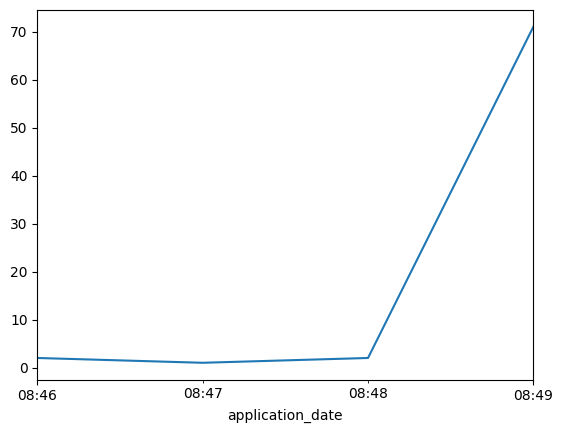

In [ ]:
/otr.groupby(by=['application_date']).count().sort_values(by=['application_date'])['service'].plot()

In [ ]:
otr = train_data[(datetime.strptime('18-02-04 02:54:00', '%y-%m-%d %H:%M:%S') < train_data['application_date']) & 
                (train_data['application_date'] <  datetime.strptime('18-02-04 02:57:00', '%y-%m-%d %H:%M:%S'))]

In [ ]:
otr['decision'].unique()

array(['КПУ настроен согласно заявки', 'Работы по обращению выполнены',
       'Выполнено', 'Доступ предоставлен', 'Доступ предоставлен.',
       'Заявка выполнена'], dtype=object)

<Axes: xlabel='application_date'>

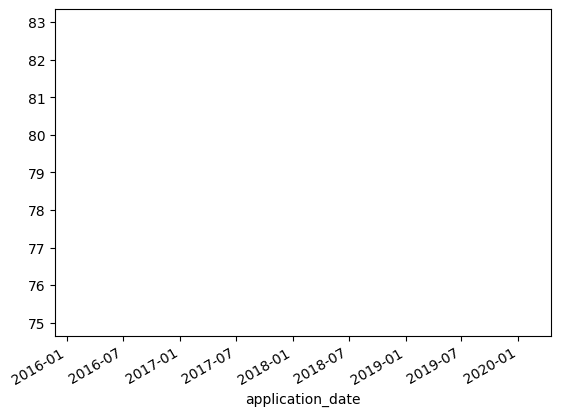

In [ ]:
otr.groupby(by=['application_date']).count().sort_values(by=['application_date'])['service'].plot()

In [ ]:
train_data[train_data['priority'] == '0-Критический']

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place
10873,Тестирование дефекта,Сервис52,0-Критический,Отменен,СВ6,2018-02-10 09:02:00,2018-02-10 08:02:00,Инцидент,Инцидент,тест,0,1970-01-01,2018-02-10 08:52:00,1-Особая,1-Всеохватывающее,Система52,Место1
11976,Тестирование,Сервис52,0-Критический,Отменен,СВ6,2018-02-11 10:38:00,2018-02-11 09:38:00,Инцидент,Инцидент,Тестирование,0,1970-01-01,2018-02-11 10:52:00,1-Особая,1-Всеохватывающее,Система52,Место1
13230,Тестовый запрос,Сервис52,0-Критический,Отменен,СВ6,2018-02-14 15:56:00,2018-02-14 14:56:00,Инцидент,Инцидент,Тестирование,0,1970-01-01,2018-02-15 06:26:00,1-Особая,1-Всеохватывающее,Система52,Место1


In [ ]:
train_data['status'].value_counts()

Закрыт     14369
Отменен      434
Name: status, dtype: int64

In [ ]:
train_data['group'].value_counts()

ФГ13     3320
ФГ12     1122
ФГ8      1103
ФГ18      787
ФГ137     407
         ... 
ФГ743       1
ФГ485       1
ФГ535       1
ФГ600       1
ФГ234       1
Name: group, Length: 555, dtype: int64

In [ ]:
train_data['criticality'].value_counts()

4-Нет           6775
1-Особая        4717
2-Повышенная    2370
3-Базовая        941
Name: criticality, dtype: int64

<Axes: xlabel='application_date'>

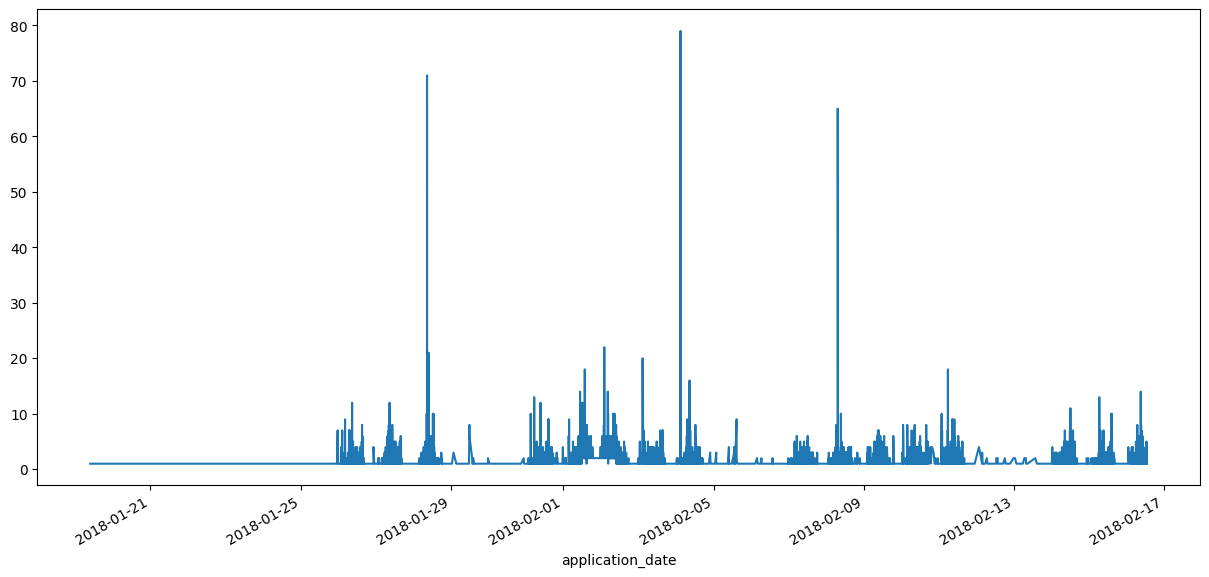

In [ ]:
plt.figure(figsize=(15,7))

train_data.groupby(by=['application_date'])['criticality'].count().plot()

In [ ]:
train_data['influence'].value_counts()

4-Нет влияния        9123
3-Малое              5615
2-Значительное         60
1-Всеохватывающее       5
Name: influence, dtype: int64

In [ ]:
train_data[train_data['influence'] == '1-Всеохватывающее']

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place
2900,.Тест. Тренировка. Переход на резервынй сервер...,Сервис34,3-Низкий,Отменен,ФГ816,2018-02-02 06:36:00,2018-01-29 00:45:00,Инцидент,Инцидент,Переход на резервный сервер выполнен в **:**. ...,0,1970-01-01,2018-01-29 02:27:00,4-Нет,1-Всеохватывающее,Система36,Место181
8101,тестовый инцидент,Сервис11,3-Низкий,Отменен,ФГ128,2018-02-09 12:36:00,2018-02-05 11:22:00,Инцидент,Инцидент,Инцидент ************,0,1970-01-01,2018-02-05 11:26:00,4-Нет,1-Всеохватывающее,Система11,Место1
10873,Тестирование дефекта,Сервис52,0-Критический,Отменен,СВ6,2018-02-10 09:02:00,2018-02-10 08:02:00,Инцидент,Инцидент,тест,0,1970-01-01,2018-02-10 08:52:00,1-Особая,1-Всеохватывающее,Система52,Место1
11976,Тестирование,Сервис52,0-Критический,Отменен,СВ6,2018-02-11 10:38:00,2018-02-11 09:38:00,Инцидент,Инцидент,Тестирование,0,1970-01-01,2018-02-11 10:52:00,1-Особая,1-Всеохватывающее,Система52,Место1
13230,Тестовый запрос,Сервис52,0-Критический,Отменен,СВ6,2018-02-14 15:56:00,2018-02-14 14:56:00,Инцидент,Инцидент,Тестирование,0,1970-01-01,2018-02-15 06:26:00,1-Особая,1-Всеохватывающее,Система52,Место1


In [ ]:
train_data['system'].value_counts()

База          3508
Система7      1719
Система13      988
Система22      966
Система2       812
              ... 
Система438       1
Система118       1
Система162       1
Система336       1
Система119       1
Name: system, Length: 201, dtype: int64

In [ ]:
train_data['place'].value_counts()

Место3      1039
Место1       744
Место32      519
К            409
Место57      327
            ... 
Место291       1
Место329       1
Место270       1
Место407       1
Место186       1
Name: place, Length: 314, dtype: int64

In [ ]:
train_data[train_data['target'] == 1]

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place
927,"Заявка Сервис27 зависла в стадии ""Ожидает утв...",Сервис11,3-Низкий,Закрыт,ФГ62,2018-02-01 04:17:00,2018-01-27 03:25:00,Запрос,Инцидент,По заявке *********** создан инцидент №*******...,1,2018-01-27 06:08:00,2018-01-27 06:29:00,4-Нет,3-Малое,Система11,Место216
935,Отсутствует загрузка ОС на ноутбуке,АРМ,3-Низкий,Закрыт,ФГ185,2018-02-04 06:54:00,2018-01-27 04:01:00,Запрос,Инцидент,Причина: Отсутствует загрузка ОС на ноутбуке\n...,1,2018-02-01 06:58:00,2018-02-08 08:23:00,4-Нет,3-Малое,База,Место20
961,Согласующему заявок не поступает сообщение по ...,Сервис11,3-Низкий,Закрыт,ФГ62,2018-02-01 06:12:00,2018-01-27 05:24:00,Запрос,Инцидент,причина - некорректная работа автосогласования...,1,2018-01-27 08:01:00,2018-01-27 08:03:00,4-Нет,3-Малое,Система11,Место174
984,Длительная загрузка,Сервис99,3-Низкий,Закрыт,ФГ162,2018-01-31 12:36:00,2018-01-27 06:15:00,Запрос,Инцидент,Работоспособность восстановлена после перезагр...,1,2018-01-28 06:51:00,2018-02-04 08:19:00,1-Особая,4-Нет влияния,Система100,Место102
1213,По обращению ************** произошел сбой рег...,Сервис11,3-Низкий,Закрыт,ФГ62,2018-02-01 09:01:00,2018-01-27 08:42:00,Запрос,Инцидент,По заявке ************* создан Инцидент №*****...,1,2018-01-27 10:52:00,2018-02-03 12:08:00,4-Нет,3-Малое,Система11,Место3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14205,нет возможности загрузить АРМ Система21,Сервис21,2-Средний,Закрыт,ФГ481,2018-02-16 10:36:00,2018-02-16 05:49:00,Запрос,Инцидент,При запуске АРМ пользователю не выдавалось лог...,1,2018-02-16 05:56:00,2018-02-23 08:26:00,1-Особая,3-Малое,Система21,Место117
14248,нет возможности зайти в АРМ Система21,Сервис21,2-Средний,Закрыт,ФГ481,2018-02-16 10:36:00,2018-02-16 06:17:00,Запрос,Инцидент,При запуске АРМ пользователю не выдавалось лог...,1,2018-02-16 06:26:00,2018-02-23 08:26:00,1-Особая,3-Малое,Система21,Место117
14603,Не ходят ответы в Система21,Сервис21,2-Средний,Закрыт,ФГ153,2018-02-16 14:06:00,2018-02-16 10:06:00,Запрос,Инцидент,Перезапуск канала между Система26 1 и Система2 1.,1,2018-02-16 10:34:00,2018-02-23 11:52:00,1-Особая,3-Малое,Система21,Место51
14785,Не работает МФУ,Сервис25,3-Низкий,Закрыт,ФГ295,2018-02-21 12:31:00,2018-02-16 12:49:00,Запрос,Инцидент,Восстановление работоспособности МФУ. Проверка...,1,2018-02-16 14:20:00,2018-02-16 14:31:00,4-Нет,4-Нет влияния,Система25,Место11


In [ ]:
train_data[train_data['final_type'] == 'Инцидент'].groupby(by=[''])

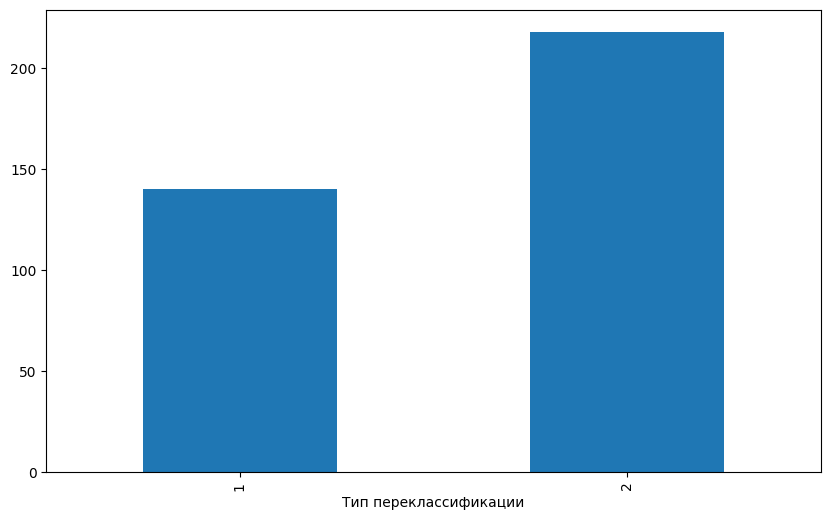

In [ ]:
plt.figure(figsize=(10, 6))

train_data[train_data['Тип переклассификации'] != 0].groupby(['Тип переклассификации'])['Сервис'].count().plot.bar()

plt.show()

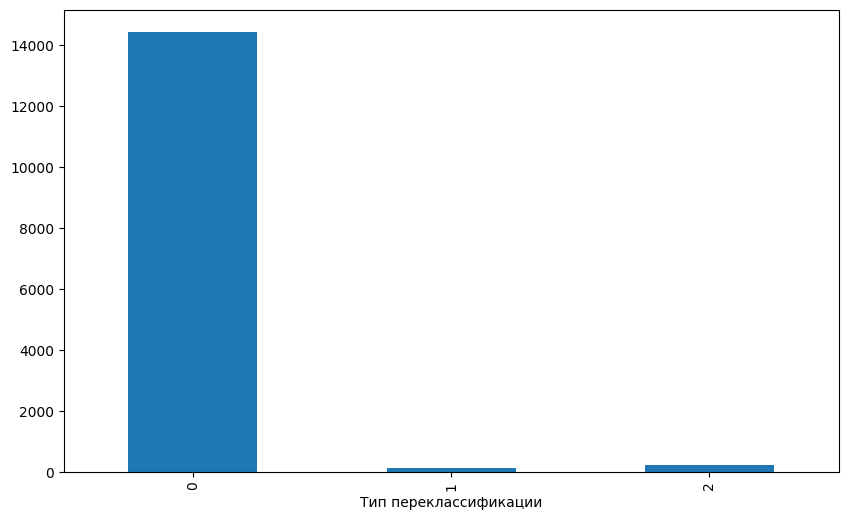

In [ ]:
plt.figure(figsize=(10, 6))

train_data.groupby(['Тип переклассификации'])['Сервис'].count().plot.bar()

plt.show()

In [ ]:
train_data[(train_data['status'] == 'Отменен') & (train_data['final_type'] == 'Инцидент')]['content_clean'].unique()

array(['работать несколько пользователь', 'шредер забиться бумага',
       'устранение ошибка', 'тест', 'тест2', 'тест работать система52',
       'система21 уровень ошибка запрос данные период 5 день',
       'установить сертификат система22 унэп',
       'тест тренировка переход резервынть сервер система435 клиент система21',
       'тест 34 выход строй основный сервер система435 уровень тот',
       'тесткомплексный тренировканарушение предоставление сервис платёжный система система21',
       'тест выход строй основный сервер система435',
       'тестирование нарушение работоспособность система435',
       'фиксироваться замедление предоставление сервис система500 web',
       'система20',
       'копия ботнаблюдение система62 отд ухудшение статус сервис', '',
       'тест нарушение доступ сетевой ресурс многочисленный обращение пользователь',
       'сообщить ошибкенеисправность система18',
       'отсутсвовать возможность вход система22', 'тестовый инцидент',
       'тестирование

In [ ]:
train_data[(train_data['status'] == 'Отменен') & (train_data['final_type'] == 'Инцидент')]

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,...,closing_date,criticality,influence,system,place,available_hours,true_hours,closing_hours,content_clean,decision_clean
433,Не может работать один или несколько Пользоват...,Сервис66,3-Низкий,Отменен,ФГ30,2018-01-31 07:38:00,2018-01-26 09:23:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,4-Нет,3-Малое,Система65,Место116,118.0,50.0,-421378.0,не мочь работать один или несколько пользователь,запрос отменить пользователь из портал самообс...
553,Шредер забился бумагой,Сервис87,3-Низкий,Отменен,ФГ188,2018-01-31 09:47:00,2018-01-26 11:32:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,4-Нет,3-Малое,Система87,Место3,118.0,20.0,-421380.0,шредер забиться бумага,запрос отменить пользователь из портал самообс...
672,Устранение ошибки,Сервис12,2-Средний,Отменен,ФГ18,2018-01-26 21:27:00,2018-01-26 13:27:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,1-Особая,3-Малое,Система35,Место13,8.0,0.0,-421382.0,устранение ошибка,запрос отменить пользователь из портал самообс...
1110,.тест,Сервис207,3-Низкий,Отменен,ФГ536,2018-01-31 15:19:00,2018-01-27 08:04:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,4-Нет,3-Малое,Система222,#Н/Д,103.0,0.0,-421401.0,тест,запрос отменить пользователь из портал самообс...
1120,.Тест2,Сервис207,3-Низкий,Отменен,ФГ536,2018-01-31 15:26:00,2018-01-27 08:11:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,4-Нет,3-Малое,Система222,#Н/Д,103.0,0.0,-421401.0,тест2,запрос отменить пользователь из портал самообс...
1308,Не может работать один или несколько Пользоват...,Сервис22,3-Низкий,Отменен,ФГ448,2018-01-31 06:55:00,2018-01-27 09:22:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,2-Повышенная,3-Малое,Система22,Место73,93.0,93.0,-421402.0,не мочь работать один или несколько пользователь,запрос отменить пользователь из портал самообс...
1602,Тест. Не работает Система52,Сервис52,1-Высокий,Отменен,СВ6,2018-01-27 17:33:00,2018-01-27 13:33:00,Инцидент,Инцидент,тест,...,2018-01-27 13:51:00,1-Особая,2-Значительное,Система52,Место1,4.0,0.0,0.0,тест не работать система52,тест
1985,.в Система21 уровень ошибка при запросе данны...,Сервис21,2-Средний,Отменен,ФГ620,2018-01-28 10:39:00,2018-01-28 06:39:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,1-Особая,3-Малое,Система21,Место91,4.0,1.0,-421423.0,в система21 уровень ошибка при запрос данные з...,запрос отменить пользователь из портал самообс...
2444,Устранение ошибки,Сервис12,2-Средний,Отменен,ФГ78,2018-01-28 17:57:00,2018-01-28 09:57:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,1-Особая,3-Малое,Система35,Место53,8.0,3.0,-421426.0,устранение ошибка,запрос отменить пользователь из портал самообс...
2842,Не установить сертификаты Система22 унэп.,Сервис22,3-Низкий,Отменен,ФГ62,2018-01-31 09:19:00,2018-01-28 14:19:00,Инцидент,Инцидент,Запрос отменён пользователем из портала самооб...,...,1970-01-01 00:00:00,2-Повышенная,3-Малое,Система22,Место254,67.0,0.0,-421431.0,не установить сертификат система22 унэп,запрос отменить пользователь из портал самообс...


In [ ]:
train_data[(train_data['status'] == 'Отменен') & (train_data['final_type'] == 'Инцидент')]['decision_clean'].unique()

array(['запрос отменить пользователь портал самообслуживание', 'тест',
       'переход резервный сервер выполнить запрос тестовый подлежать перевод статус отменный',
       'тестирование сценарий восстановление',
       'запрос отменный являться тестовый зарегистрировать рамка комплексный тренировка',
       'тестирование сценарий востановление', 'тестовый запрос',
       'дублировать запрос', 'зарегистрировать ошибочно', 'инцидент',
       'тестовый', 'тестирование'], dtype=object)

# Feature engineering

In [ ]:
train_data['available_hours'] = (train_data.deadline - train_data.application_date).dt.total_seconds() // 3600

# train_data['true_hours'] = (train_data.repair_date - train_data.application_date).dt.total_seconds() // 3600

# train_data['closing_hours'] = (train_data.closing_date - train_data.application_date).dt.total_seconds() // 3600

In [ ]:
train_data.head()

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place,available_hours,true_hours,closing_hours
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42:00,2018-01-19 09:27:00,Запрос,Запрос,Тест,0,1970-01-01 00:00:00,2018-01-19 09:43:00,4-Нет,3-Малое,База,К,118.0,-421210.0,0.0
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51:00,2018-01-19 09:36:00,Запрос,Запрос,Тест,0,1970-01-01 00:00:00,2018-01-19 09:41:00,4-Нет,3-Малое,База,К,121.0,-421210.0,0.0
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51:00,2018-01-25 22:47:00,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47:00,2018-02-02 07:52:00,1-Особая,3-Малое,Система7,Место190,129.0,0.0,177.0
3,.Не включается ПК,АРМ,3-Низкий,Закрыт,ФГ390,2018-01-28 05:50:00,2018-01-25 23:13:00,Инцидент,Инцидент,Выход из стоя БП. Заменён.,0,2018-01-25 23:55:00,2018-01-26 00:00:00,4-Нет,3-Малое,База,Место177,54.0,0.0,0.0
4,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ303,2018-02-03 02:51:00,2018-01-25 23:39:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-28 02:54:00,2018-02-04 07:53:00,4-Нет,4-Нет влияния,База,Место216,195.0,51.0,224.0


# Model

## Cleaning text

In [ ]:
def clean_text(text):
    text = str(text)
    table = text.maketrans(dict.fromkeys(string.punctuation))
    
    words = word_tokenize(text.lower().strip().translate(table))
    # words = [word for word in words if word not in stopwords.words('russian')]
    lemmed = [WordNetLemmatizer().lemmatize(word) for word in words]    
    return " ".join(lemmed)

In [ ]:
train_data['content_clean'] = train_data['content'].apply(clean_text)
train_data['decision_clean'] = train_data['decision'].apply(clean_text)

In [ ]:
train_data.head()

,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place,available_hours,content_clean,decision_clean
0,Тест,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 07:42:00,2018-01-19 09:27:00,Запрос,Запрос,Тест,0,1970-01-01 00:00:00,2018-01-19 09:43:00,4-Нет,3-Малое,База,К,118.0,тест,тест
1,Тестовое обращение,АРМ,3-Низкий,Отменен,ФГ1,2018-01-24 10:51:00,2018-01-19 09:36:00,Запрос,Запрос,Тест,0,1970-01-01 00:00:00,2018-01-19 09:41:00,4-Нет,3-Малое,База,К,121.0,тестовое обращение,тест
2,Выполнена разблокировка у/з REGION\*****,Сервис7,2-Средний,Закрыт,ФГ8,2018-01-31 07:51:00,2018-01-25 22:47:00,Запрос,Запрос,Выполнена разблокировка у/з Ne_bosS\*********\...,0,2018-01-25 22:47:00,2018-02-02 07:52:00,1-Особая,3-Малое,Система7,Место190,129.0,выполнена разблокировка уз region,выполнена разблокировка уз nebo идентификация ...
3,.Не включается ПК,АРМ,3-Низкий,Закрыт,ФГ390,2018-01-28 05:50:00,2018-01-25 23:13:00,Инцидент,Инцидент,Выход из стоя БП. Заменён.,0,2018-01-25 23:55:00,2018-01-26 00:00:00,4-Нет,3-Малое,База,Место177,54.0,не включается пк,выход из стоя бп заменён
4,"Заявка № ***********, *******************",АРМ,3-Низкий,Закрыт,ФГ303,2018-02-03 02:51:00,2018-01-25 23:39:00,Запрос,Запрос,Работы по обращению выполнены,0,2018-01-28 02:54:00,2018-02-04 07:53:00,4-Нет,4-Нет влияния,База,Место216,195.0,заявка №,работы по обращению выполнены


## Catboost

In [ ]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

bad_features = ['system', 'place', 'service', 'criticality', 'final_type','deadline',
                'repair_date', 'closing_date', 'application_date','content','decision']

cleaned_train = train_data.drop(bad_features, axis=1)

X = cleaned_train.drop(['target'], axis=1)
y = cleaned_train['target']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
xtrain.columns

Index(['priority', 'status', 'group', 'original_type', 'influence',
       'available_hours', 'content_clean', 'decision_clean'],
      dtype='object')

In [ ]:
from catboost import CatBoostClassifier, Pool


cat_features =['priority', 'status', 'group', 'original_type', 'influence']
text_features = ['content_clean', 'decision_clean']

train_pool = Pool(
    xtrain, 
    ytrain, 
    text_features=text_features,
    cat_features=cat_features
    
)
valid_pool = Pool(
    xtest, 
    ytest,
    text_features=text_features, 
    cat_features=cat_features
)

In [ ]:
catboost_params = {
    # 'iterations': 1500,
    # 'learning_rate': 0.0001,
    # 'eval_metric': 'TotalF1:use_weights=false;average=Macro',
    # 'auto_class_weights': 'SqrtBalanced',

    # tuned parametrs
    'learning_rate': 0.09825109993288812,
    'depth': 7,
    'l2_leaf_reg': 0.0004531514155747686,
    'bootstrap_type': 'Bayesian',
    'random_strength': 1.6365428836831727e-06,
    'bagging_temperature': 5.226447139124548,
    'od_type': 'IncToDec',
    'auto_class_weights': 'Balanced',

    'eval_metric': 'TotalF1:use_weights=false;average=Macro',
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'use_best_model': True,
    
    'verbose':100
}

model = CatBoostClassifier(**catboost_params)
model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.7068269	test: 0.8454418	best: 0.8454418 (0)	total: 83.4ms	remaining: 1m 23s
100:	learn: 0.8318415	test: 0.9196912	best: 0.9225216 (93)	total: 6.04s	remaining: 53.7s
200:	learn: 0.9062847	test: 0.9190990	best: 0.9254079 (147)	total: 13.8s	remaining: 54.9s
300:	learn: 0.9500745	test: 0.9190990	best: 0.9254079 (147)	total: 18.2s	remaining: 42.2s
400:	learn: 0.9780840	test: 0.9295945	best: 0.9305347 (372)	total: 19.3s	remaining: 28.8s
500:	learn: 0.9854980	test: 0.9448359	best: 0.9448359 (497)	total: 20.4s	remaining: 20.3s
600:	learn: 0.9921607	test: 0.9273374	best: 0.9448359 (497)	total: 21.5s	remaining: 14.3s
700:	learn: 0.9975346	test: 0.9202649	best: 0.9448359 (497)	total: 23.7s	remaining: 10.1s
800:	learn: 0.9975346	test: 0.9202649	best: 0.9448359 (497)	total: 26.9s	remaining: 6.68s
900:	learn: 0.9990305	test: 0.9202649	best: 0.9448359 (497)	total: 28s	remaining: 3.07s
999:	learn: 0.9990305	test: 0.9202649	best: 0.9448359 (497)	total: 29s	remaining: 0us
bestTest = 0.944835

In [ ]:
import pickle

pickle.dump(model, open('clf_model.pkl', 'wb'))

### features importance

На график нанесено топ-13 признаков


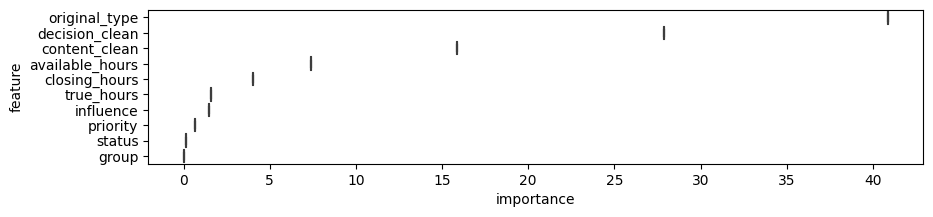

In [ ]:
def plot_importance(df, best_model, height = 0.2, top_n=50):

    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:, [0, 2]]  # .to_frame()
    fi.columns = ["feature", "importance"]

    cols_ord = list(fi.groupby("feature")["importance"].mean().sort_values(ascending=False).index)
    
    # print("Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))
    cols_ord = cols_ord[:top_n]

    fi = fi[fi["feature"].isin(cols_ord)]

    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False))


df_feats_imp = plot_importance(
    X,
    best_model = [model],
    height = 0.20,
    top_n=13,
)

In [ ]:
model.get_feature_importance()

array([ 0.75263325,  0.19357938,  0.        , 47.76106388,  1.3316305 ,
        9.55521407, 15.95906139, 24.44681753])

### crossval

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 3
clfs = [] 
scores = [] 


kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X,y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    cat_features =['priority', 'status', 'group', 'original_type', 'influence']
    text_features = ['content_clean', 'decision_clean']

    train_dataset = Pool(
        X_train, 
        y_train,
        text_features=text_features,
        cat_features=cat_features
        
    )
    eval_dataset = Pool(
        X_test, 
        y_test,
        text_features=text_features, 
        cat_features=cat_features
    )

    clf = CatBoostClassifier(**catboost_params)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)
    # train_unique, train_counts = np.unique(y_train, return_counts=True)
    # print(f'0 - {train_counts[0]/sum(train_counts)*100}%, 1 - {train_counts[1]/sum(train_counts)*100}%, 2 - {train_counts[2]/sum(train_counts)*100}%')

    # unique, counts = np.unique(y_test, return_counts=True)
    # print(f'0 - {counts[0]/sum(counts)*100}%, 1 - {counts[1]/sum(counts)*100}%, 2 - {counts[2]/sum(counts)*100}%')

    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "TotalF1:use_weights=false;average=Macro" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print("mean TotalF1:use_weights=false;average=Macro score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))

0:	learn: 0.5947275	test: 0.6310936	best: 0.6310936 (0)	total: 21.9ms	remaining: 21.9s
500:	learn: 0.9947353	test: 0.8906465	best: 0.8959960 (477)	total: 10.4s	remaining: 10.4s
999:	learn: 0.9988372	test: 0.8985479	best: 0.9053034 (954)	total: 15.7s	remaining: 0us
bestTest = 0.9053033803
bestIteration = 954
Shrink model to first 955 iterations.
0:	learn: 0.6342250	test: 0.6473384	best: 0.6473384 (0)	total: 21.6ms	remaining: 21.5s
500:	learn: 0.9941389	test: 0.9038529	best: 0.9063137 (472)	total: 8.96s	remaining: 8.92s
999:	learn: 0.9988372	test: 0.9079833	best: 0.9104476 (704)	total: 14.8s	remaining: 0us
bestTest = 0.9104475902
bestIteration = 704
Shrink model to first 705 iterations.
0:	learn: 0.6268221	test: 0.6269602	best: 0.6269602 (0)	total: 54.9ms	remaining: 54.9s
500:	learn: 0.9970452	test: 0.9021845	best: 0.9058173 (413)	total: 6.32s	remaining: 6.3s
999:	learn: 1.0000000	test: 0.9165508	best: 0.9165508 (919)	total: 13.9s	remaining: 0us
bestTest = 0.9165508406
bestIteration = 91

### tuning with optuna

In [ ]:
import optuna
from optuna.samplers import TPESampler

In [ ]:
def objective(trial):
    model = CatBoostClassifier(
        # iterations=trial.suggest_int("iterations", 100, 1000),
        iterations=1500,
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 8),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        # od_wait=trial.suggest_int("od_wait", 10, 50),
        auto_class_weights =trial.suggest_categorical('auto_class_weights',['SqrtBalanced', 'Balanced']),
        verbose=False,

        eval_metric = 'TotalF1:use_weights=false;average=Macro',
        task_type = 'GPU',
        early_stopping_rounds = 100,
        use_best_model = True,
    )
    model.fit(train_pool, eval_set=valid_pool)
    y_pred = model.predict(xtest)
    return f1_score(ytest, y_pred, average='macro')

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value:  0.94483593700985
  Params: 
    learning_rate: 0.09825109993288812
    depth: 7
    l2_leaf_reg: 0.0004531514155747686
    bootstrap_type: Bayesian
    random_strength: 1.6365428836831727e-06
    bagging_temperature: 5.226447139124548
    od_type: IncToDec
    auto_class_weights: Balanced


In [ ]:
trial.params

{'learning_rate': 0.09825109993288812,
 'depth': 7,
 'l2_leaf_reg': 0.0004531514155747686,
 'bootstrap_type': 'Bayesian',
 'random_strength': 1.6365428836831727e-06,
 'bagging_temperature': 5.226447139124548,
 'od_type': 'IncToDec',
 'auto_class_weights': 'Balanced'}

### scoring

In [ ]:
from sklearn.metrics import f1_score

preds = model.predict(xtest)

print(f1_score(ytest, preds, average='macro'))

0.94483593700985


In [ ]:
unique, counts = np.unique(ytrain, return_counts=True)
counts

array([11556,   112,   174])

In [ ]:
print(f'0 - {counts[0]/sum(counts)*100}%, 1 - {counts[1]/sum(counts)*100}%, 2 - {counts[2]/sum(counts)*100}%')

0 - 97.58486742104374%, 1 - 0.9457861847660868%, 2 - 1.4693463941901705%


# inference

In [ ]:
test_data = pd.read_csv('test.csv')
new_names = {'Содержание':'content', 'Сервис':'service', 'Приоритет':'priority', 'Статус': 'status', 'Функциональная группа':'group',
             'Крайний срок':'deadline', 'Дата обращения':'application_date', 'Тип обращения на момент подачи':'original_type',
             'Тип обращения итоговый':'final_type', 'Решение             ':'decision', 'Тип переклассификации':'target', 'Дата восстановления':'repair_date', 'Дата закрытия обращения':'closing_date', 'Критичность':'criticality', 'Влияние':'influence', 'Система':'system', 'Место':'place'}
test_data.rename(columns = new_names, inplace = True)


test_data.deadline = test_data.deadline.apply(pd.to_datetime)
test_data.application_date = test_data.application_date.apply(pd.to_datetime)
test_data['available_hours'] = (test_data.deadline - test_data.application_date).dt.total_seconds() // 3600


test_data.head()

,id,content,service,priority,status,group,deadline,application_date,original_type,final_type,decision,target,repair_date,closing_date,criticality,influence,system,place,available_hours
0,14803,Заявка на предоставление и отзыв прав доступа ...,Сервис41,3-Низкий,Закрыт,ФГ13,2018-02-22 07:51:00,2018-02-16 13:11:00,Запрос,NaN,Работы по обращению выполнены,NaN,2018-02-18 04:32,2018-02-25 07:56,4-Нет,4-Нет влияния,Система43,Место38,138.0
1,14804,Транспортный шлюз,Сервис61,2-Средний,Закрыт,ФГ1,2018-02-21 14:36:00,2018-02-16 13:13:00,Запрос,NaN,проинф у.о.,NaN,2018-02-16 17:55,2018-02-24 07:54,1-Особая,3-Малое,Система61,К,121.0
2,14805,Заявка на предоставление и отзыв прав доступа ...,Сервис22,3-Низкий,Закрыт,ФГ13,2018-03-31 06:36:00,2018-02-16 13:13:00,Запрос,NaN,Работы по обращению выполнены,NaN,2018-03-15 16:09,2018-03-23 07:56,2-Повышенная,4-Нет влияния,Система13,Место25,1025.0
3,14806,Заявка на предоставление и отзыв прав доступа ...,Сервис91,3-Низкий,Отменен,ФГ13,2018-02-21 14:29:00,2018-02-16 13:14:00,Запрос,NaN,Запрос отменён пользователем из портала самооб...,NaN,2018-02-16 13:15,NaN,2-Повышенная,4-Нет влияния,Система363,Место1,121.0
4,14807,Заявка на предоставление и отзыв прав доступа ...,Сервис22,3-Низкий,Закрыт,ФГ13,2018-03-30 09:36:00,2018-02-16 13:14:00,Запрос,NaN,Работы по обращению выполнены,NaN,2018-03-15 16:09,2018-03-23 07:56,2-Повышенная,4-Нет влияния,Система13,Место25,1004.0


In [ ]:
test_data['content_clean'] = test_data['content'].apply(clean_text)
test_data['decision_clean'] = test_data['decision'].apply(clean_text)

In [ ]:
bad_features = ['system', 'place', 'service', 'criticality', 'final_type','deadline',
                'repair_date', 'closing_date', 'application_date','content','decision']

cleaned_test = test_data.drop(bad_features, axis=1)
cleaned_test.head()

,id,priority,status,group,original_type,target,influence,available_hours,content_clean,decision_clean
0,14803,3-Низкий,Закрыт,ФГ13,Запрос,NaN,4-Нет влияния,138.0,заявка на предоставление и отзыв прав доступа ...,работы по обращению выполнены
1,14804,2-Средний,Закрыт,ФГ1,Запрос,NaN,3-Малое,121.0,транспортный шлюз,проинф уо
2,14805,3-Низкий,Закрыт,ФГ13,Запрос,NaN,4-Нет влияния,1025.0,заявка на предоставление и отзыв прав доступа ...,работы по обращению выполнены
3,14806,3-Низкий,Отменен,ФГ13,Запрос,NaN,4-Нет влияния,121.0,заявка на предоставление и отзыв прав доступа ...,запрос отменён пользователем из портала самооб...
4,14807,3-Низкий,Закрыт,ФГ13,Запрос,NaN,4-Нет влияния,1004.0,заявка на предоставление и отзыв прав доступа ...,работы по обращению выполнены


In [ ]:
from catboost import Pool
cat_features =['priority', 'status', 'group', 'original_type', 'influence']
text_features = ['content_clean', 'decision_clean']

valid_pool = Pool(
    cleaned_test.drop(['id', 'target'],axis=1),
    text_features=text_features, 
    cat_features=cat_features
)

In [ ]:
import pickle

pickled_model = pickle.load(open('clf_model.pkl', 'rb'))
target_preds = pickled_model.predict(cleaned_test.drop(['id', 'target'],axis=1))

In [ ]:
test_data['target'] = target_preds

In [ ]:
test_data.iloc[0]

id                                                              14803
content             Заявка на предоставление и отзыв прав доступа ...
service                                                      Сервис41
priority                                                     3-Низкий
status                                                         Закрыт
group                                                            ФГ13
deadline                                          2018-02-22 07:51:00
application_date                                  2018-02-16 13:11:00
original_type                                                  Запрос
final_type                                                        NaN
decision                                Работы по обращению выполнены
target                                                              0
repair_date                                          2018-02-18 04:32
closing_date                                         2018-02-25 07:56
criticality         

In [ ]:
test_data['final_type'] = test_data.apply(lambda x: 'Инцидент' if x[11] == 1 else 'Запрос' if x[11] == 2 else x[8], axis=1)

In [ ]:
test_data.columns

Index(['id', 'content', 'service', 'priority', 'status', 'group', 'deadline',
       'application_date', 'original_type', 'final_type', 'decision', 'target',
       'repair_date', 'closing_date', 'criticality', 'influence', 'system',
       'place', 'available_hours', 'content_clean', 'decision_clean'],
      dtype='object')

In [ ]:
sub_df = test_data.drop(['content', 'service', 'priority', 'status', 'group', 'deadline',
       'application_date', 'original_type', 'decision',
       'repair_date', 'closing_date', 'criticality', 'influence', 'system',
       'place', 'available_hours', 'content_clean', 'decision_clean'], axis=1)

In [ ]:
sub_df.rename(columns = {'final_type':'Тип обращения итоговый', 'target': 'Тип переклассификации'}, inplace = True)

In [ ]:
sub_df=sub_df.reindex(columns=['id', 'Тип переклассификации', 'Тип обращения итоговый'])
sub_df.head()

,id,Тип переклассификации,Тип обращения итоговый
0,14803,0,Запрос
1,14804,0,Запрос
2,14805,0,Запрос
3,14806,0,Запрос
4,14807,0,Запрос


In [ ]:
sub_df.to_csv('cp_submission.csv', index=False)

In [ ]:
sub_df['Тип переклассификации'].value_counts()

0    5944
2     353
1      47
Name: Тип переклассификации, dtype: int64